In [3]:
import sys 
sys.path.insert(0,'../')

In [ ]:
from io_models import*
from data import* 
from Unet_models import*
from segmentation import*

import h5py as h5
import patchify as patch
import cv2

In [ ]:
# check availible GPUS and set memory growth 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

In [6]:
# set mixed precision (32/16 bit) presision
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0


## Segment grains

In [27]:
data_path = '/home/m_fokin/NN/Data/data_exp2/exp2_time_19p6_101_102_107to110_113to185.h5'
# load data
data_raw = load_h5_dataset(data_path, dset_number = 25, dtype = np.uint8)
data_patches = prepare_patches(data_raw, patch_size=(256,256,256), patch_step=(128,242,242))
# load model
model = UNet_3D(input_size = (256,256,256,1))
model.load_weights("/home/m_fokin/NN/Unet_3D_2D/weights/UNet_3D__16_256.hdf5")
batch_size = 1 
# segmentation
segmented_patches = Unet_segmentation(data_patches[0], model, batch_size, patches_shape=data_patches[1])
data_segmented = recon_3d(segmented_patches, patch_step = (128,242,242), patch_size = (256, 256, 256), recon_shape = (512, 1224, 1224))

75/75 [==============================] - 12s 161ms/step


In [28]:
# threshold
data_segmented[data_segmented >= 0.8] = 1 
data_segmented[data_segmented < 0.8] = 0 

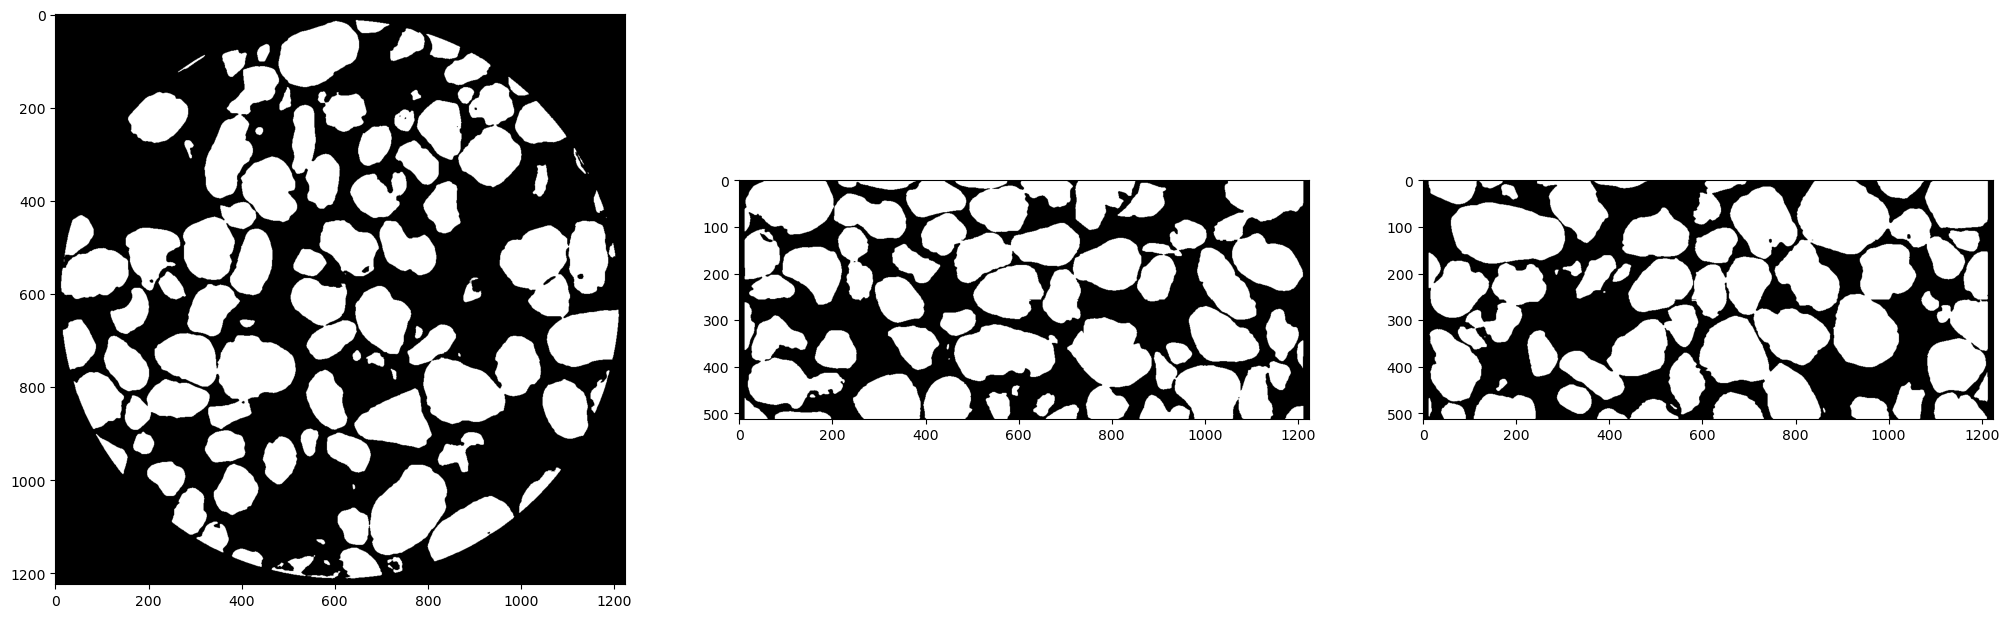

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize = (25,25))

plt.subplot(1,3,1)
plt.imshow(data_segmented[256,:,:], cmap = 'gray')

plt.subplot(1,3,2)
plt.imshow(data_segmented[:,612,:], cmap = 'gray')

plt.subplot(1,3,3)
plt.imshow(data_segmented[:,:,612], cmap = 'gray')

## GMM segmentation

### Extract grains 

In [30]:
# generate and apply circle mask
mask = circle_mask(size = 1224, radius = 599)
data = data_raw * (1 - data_segmented) * mask
data = data.astype(np.uint8)

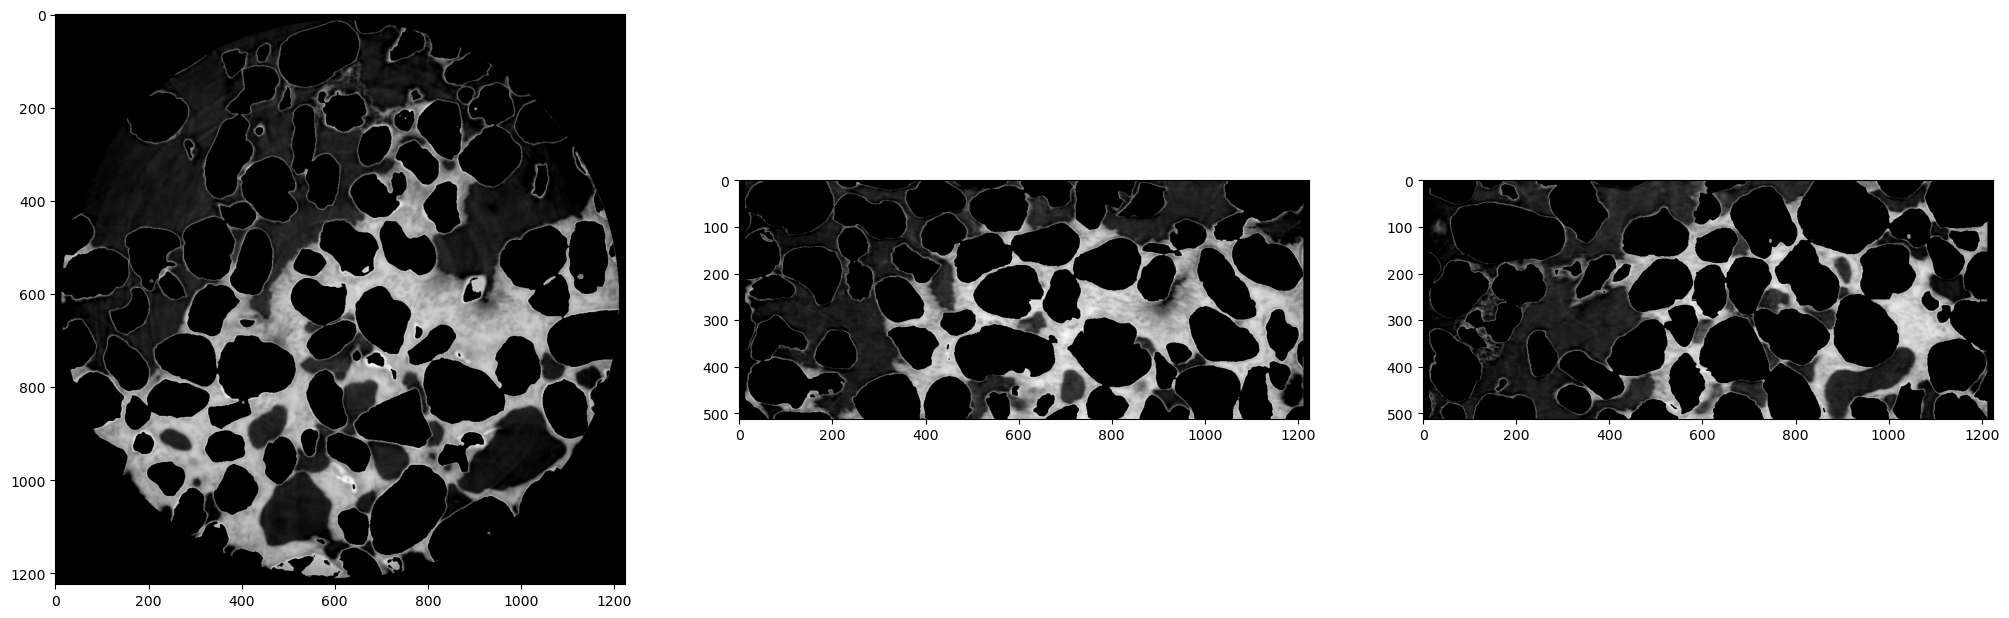

In [31]:
plt.figure(figsize = (25,25))

plt.subplot(1,3,1)
plt.imshow(data[256,:,:], cmap = 'gray')

plt.subplot(1,3,2)
plt.imshow(data[:,612,:], cmap = 'gray')

plt.subplot(1,3,3)
plt.imshow(data[:,:,612], cmap = 'gray')

### 3.2. Fit GMM

In [33]:
# step for 1D data
data_step = 50 
# transform 2D to 1D
data_1d = data.ravel()
data_1d = data_1d[data_1d != 0] 
# Fit GMM
gmm = GaussianMixture(n_components = 4, max_iter=200, tol=1e-3, covariance_type = 'full', verbose = 0)               
gmm = gmm.fit(X = np.expand_dims(data_1d[::data_step],1))
# get parameters from GMM 
cov = gmm.covariances_
means = gmm.means_
weights = gmm.weights_

In [34]:
# calcualte histogram
hist_3D = np.zeros([256, 1], dtype = np.float32)
for i in range (data.shape[0]):
    hist = cv2.calcHist([data[i,:,:]],[0],None,[256],[0,256])
    hist[0] = 0
    hist_3D = hist_3D + hist

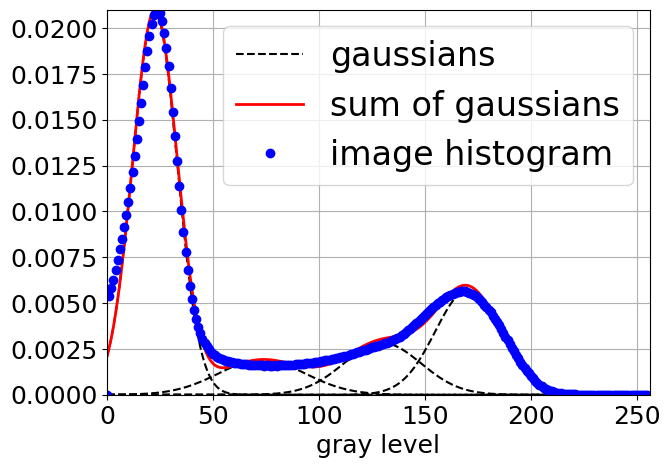

In [35]:
gmm_x = np.linspace(0,255,256)
gmm_y = np.exp(gmm.score_samples(gmm_x.reshape(-1,1)))

g1 = univariate_normal(gmm_x, means[0], cov[0][0]) * weights[0]
g2 = univariate_normal(gmm_x, means[1], cov[1][0]) * weights[1]
g3 = univariate_normal(gmm_x, means[2], cov[2][0]) * weights[2]
g4 = univariate_normal(gmm_x, means[3], cov[3][0]) * weights[3]

norm = gmm_y.max()/hist_3D.max()
xmax = (hist_3D * norm).max()
 
plt.figure(figsize = (7,5))
plt.grid()
plt.plot(g1, 'k--', label = "gaussians")
plt.plot(g2, 'k--')
plt.plot(g3, 'k--')
plt.plot(g4, 'k--')
plt.ylim(0, xmax)
plt.xlim(0, 256)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('gray level', fontsize = 18)
plt.plot(gmm_x, gmm_y, color="r", lw=2, label="sum of gaussians")
plt.plot(hist_3D * norm, 'bo', label="image histogram")
plt.legend(prop={'size': 24})

In [36]:
# predict labels
gmm_labels = gmm.predict(np.expand_dims(data_1d,1))

In [40]:
# convert 1D labels to 3D mask
result = np.zeros(data_segmented.shape, dtype = np.uint8)
result[np.where(data != 0)] = gmm_labels + 1
result = result + mask
#result[np.where(data_raw == 0) ] = 2 

In [ ]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.imshow(result[256])

plt.subplot(1,2,2)
plt.imshow(data[256], cmap = 'gray')